<a href="https://colab.research.google.com/github/eoinleen/AKTA-Prime_final/blob/main/Final_AKTA_SEC_xls_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data from /content/drive/MyDrive/SEC-data/20250326-human_mysm1.xls...
Found 18 columns in the data file
Absorbance (mAu) range: -0.029 to 269.365
Volume (ml1) range: 0.0 to 103.90996477463774
Conductivity range: 13.86 to 14.395
Loaded 960 data points successfully
Main peak detected: 269.37 mAU at 65.77 ml
Selected 12 data points in fraction range 60.65-72.75 ml
Selected 7 data points in concentration range 62.85-69.45 ml

Fraction Information (Volume vs. Fraction Number):
------------------------------------------------
Volume: 50.75 ml - Fraction: 48 
Volume: 51.85 ml - Fraction: 49 
Volume: 52.95 ml - Fraction: 50 
Volume: 54.05 ml - Fraction: 51 
Volume: 55.15 ml - Fraction: 52 
Volume: 56.25 ml - Fraction: 53 
Volume: 57.35 ml - Fraction: 54 
Volume: 58.45 ml - Fraction: 55 
Volume: 59.55 ml - Fraction: 56 
Volume: 60.65 ml - Fraction: 57 
Volume: 61.75 ml - Fraction: 58 
Volume: 62.85 ml - Fraction: 59 * CONCENTRATED *
Volume: 63.95 ml - Fraction: 60 * CONCENTRATED *
Volum

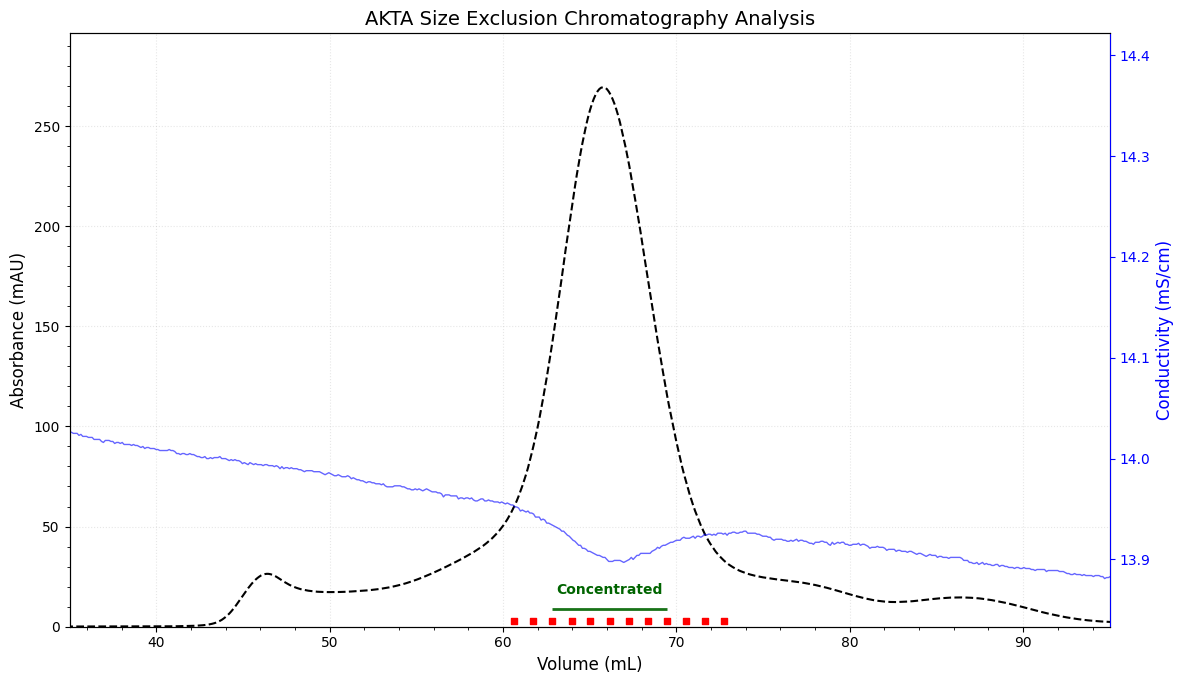

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import os
import warnings

# ==============================================================================
# CONFIGURATION SECTION - MODIFY THESE VALUES AS NEEDED
# ==============================================================================
# File path to your XLS data file
FILE_PATH = '/content/drive/MyDrive/SEC-data/20250326-human_mysm1.xls'

# Fraction collection range (in mL)
FRACTION_START = 60.65
FRACTION_END = 72.75

# Concentrated fractions range (subset of fractions to be concentrated)
# Specific fractions 59-65 (volumes from the list provided)
CONCENTRATE_START = 62.85  # Starting point for concentration (Fraction 59)
CONCENTRATE_END = 69.45    # Ending point for concentration (Fraction 65)

# Display range on the x-axis (in mL)
X_AXIS_MIN = 35
X_AXIS_MAX = 95

# Direct column indices for your specific AKTA file format
# These are 0-based indices (first column = 0)
VOLUME_COLUMN = 0        # ml (volume) column
ABSORBANCE_COLUMN = 1    # mAu (absorbance) column
CONDUCTIVITY_COLUMN = 3  # mS/cm (conductivity) column
FRACTION_VOL_COLUMN = 12  # ml for fractions
FRACTION_NUM_COLUMN = 13  # Fraction numbers

# Other settings
SHOW_CONDUCTIVITY = True      # Show conductivity trace
SAVE_OUTPUT = True            # Save plot to file
OUTPUT_PATH = './sec_plot.png'  # Where to save the plot
SHOW_LEGEND = False           # Whether to display the legend
SHOW_FRACTION_LABEL = False   # Whether to show the fraction range label
SHOW_CONCENTRATION = True     # Whether to show concentrated fractions
# ==============================================================================

def analyze_sec_data(file_path, config=None):
    """
    Analyze Size Exclusion Chromatography data from AKTA and create visualization

    Args:
        file_path (str): Path to the XLS file
        config (dict, optional): Configuration parameters for analysis and visualization

    Returns:
        tuple: (DataFrame, dict) - Processed data and analysis results
    """
    # Default configuration
    default_config = {
        'header_row': 2,  # Using row 2 (third row) which usually has ml, mAu etc.
        'fraction_range': (FRACTION_START, FRACTION_END),
        'concentrate_range': (CONCENTRATE_START, CONCENTRATE_END),
        'x_axis_limits': (X_AXIS_MIN, X_AXIS_MAX),
        'show_conductivity': SHOW_CONDUCTIVITY,
        'save_output': SAVE_OUTPUT,
        'output_path': OUTPUT_PATH,
        'volume_column': VOLUME_COLUMN,
        'absorbance_column': ABSORBANCE_COLUMN,
        'conductivity_column': CONDUCTIVITY_COLUMN,
        'fraction_vol_column': FRACTION_VOL_COLUMN,
        'fraction_num_column': FRACTION_NUM_COLUMN,
        'show_legend': SHOW_LEGEND,
        'show_fraction_label': SHOW_FRACTION_LABEL,
        'show_concentration': SHOW_CONCENTRATION
    }

    # Use default config updated with provided config
    if config is None:
        config = {}
    conf = {**default_config, **config}

    # Verify input file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Input file not found: {file_path}")

    # Load data from file
    print(f"Loading data from {file_path}...")
    try:
        # First, read in the raw data
        warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
        df_raw = pd.read_excel(file_path, header=conf['header_row'])

        # Print some information about the file
        print(f"Found {len(df_raw.columns)} columns in the data file")

        # Create a new DataFrame for our analysis
        df = pd.DataFrame()

        # Extract data using the specified column indices
        # Main volume and absorbance data
        df['ml1'] = pd.to_numeric(df_raw.iloc[:, conf['volume_column']], errors='coerce')
        df['mAu'] = pd.to_numeric(df_raw.iloc[:, conf['absorbance_column']], errors='coerce')

        # Get conductivity data
        cond_col = conf['conductivity_column']
        cond_vol_col = conf['volume_column'] + 2  # Usually volume column for conductivity
        if cond_col < len(df_raw.columns):
            df['ml2'] = pd.to_numeric(df_raw.iloc[:, cond_vol_col], errors='coerce')
            df['mS/cm'] = pd.to_numeric(df_raw.iloc[:, cond_col], errors='coerce')
        else:
            df['ml2'] = df['ml1']
            df['mS/cm'] = 0
            conf['show_conductivity'] = False

        # Get fraction data
        frac_vol_col = conf['fraction_vol_column']
        frac_num_col = conf['fraction_num_column']

        if frac_vol_col < len(df_raw.columns):
            df['ml4'] = pd.to_numeric(df_raw.iloc[:, frac_vol_col], errors='coerce')
            if frac_num_col < len(df_raw.columns):
                df['Fractions'] = df_raw.iloc[:, frac_num_col].astype(str)
            else:
                df['Fractions'] = ""
        else:
            df['ml4'] = df['ml1']
            df['Fractions'] = ""

        # Clean the data
        df = df.dropna(subset=['ml1', 'mAu'])

        # Print data ranges for verification
        print(f"Absorbance (mAu) range: {df['mAu'].min()} to {df['mAu'].max()}")
        print(f"Volume (ml1) range: {df['ml1'].min()} to {df['ml1'].max()}")
        if conf['show_conductivity']:
            print(f"Conductivity range: {df['mS/cm'].min()} to {df['mS/cm'].max()}")

        print(f"Loaded {len(df)} data points successfully")

    except Exception as e:
        raise RuntimeError(f"Error reading data file: {e}")

    # Analyze data
    results = {}

    # Find the main peak
    if len(df) > 0:
        max_absorbance = df['mAu'].max()
        max_absorbance_idx = df['mAu'].idxmax()
        max_absorbance_vol = df.loc[max_absorbance_idx, 'ml1']
        results['max_absorbance'] = {
            'value': max_absorbance,
            'volume': max_absorbance_vol
        }
        print(f"Main peak detected: {max_absorbance:.2f} mAU at {max_absorbance_vol:.2f} ml")
    else:
        print("No valid data points found!")
        return None, None, None

    # Filter for fraction range
    fraction_start, fraction_end = conf['fraction_range']
    fractions_df = df[(df['ml4'] >= fraction_start) & (df['ml4'] <= fraction_end)]
    results['fractions'] = {
        'range': conf['fraction_range'],
        'count': len(fractions_df)
    }
    print(f"Selected {len(fractions_df)} data points in fraction range {fraction_start:.2f}-{fraction_end:.2f} ml")

    # Filter for concentrated fractions
    concentrate_start, concentrate_end = conf['concentrate_range']
    concentrate_df = df[(df['ml4'] >= concentrate_start) & (df['ml4'] <= concentrate_end)]
    results['concentrate'] = {
        'range': conf['concentrate_range'],
        'count': len(concentrate_df)
    }
    print(f"Selected {len(concentrate_df)} data points in concentration range {concentrate_start:.2f}-{concentrate_end:.2f} ml")

    # Extract fraction information for console display only (not for labeling)
    fraction_rows = df[df['Fractions'].str.strip() != ''].copy()

    # Clean fraction numbers - try to extract numeric part
    def extract_number(val):
        try:
            if pd.isna(val) or val == '':
                return ''
            # Try to find numeric part
            import re
            match = re.search(r'(\d+)', str(val))
            if match:
                return match.group(1)
            return str(val)
        except:
            return str(val)

    fraction_rows['FractionNum'] = fraction_rows['Fractions'].apply(extract_number)

    # Print fraction information in our range of interest
    if len(fraction_rows) > 0:
        print("\nFraction Information (Volume vs. Fraction Number):")
        print("------------------------------------------------")

        # Filter to fractions near our range
        display_fractions = fraction_rows[
            (fraction_rows['ml4'] >= fraction_start - 10) &
            (fraction_rows['ml4'] <= fraction_end + 10)
        ].sort_values(by='ml4')

        for _, row in display_fractions.iterrows():
            is_concentrated = (row['ml4'] >= concentrate_start) and (row['ml4'] <= concentrate_end)
            conc_indicator = "* CONCENTRATED *" if is_concentrated else ""
            print(f"Volume: {row['ml4']:.2f} ml - Fraction: {row['FractionNum']} {conc_indicator}")
    else:
        print("\nNo fraction information found in the data")

    # Create visualization
    fig, ax1 = create_plot(df, fractions_df, concentrate_df, conf, results)

    # Save if requested
    if conf['save_output']:
        plt.savefig(conf['output_path'], dpi=300, bbox_inches='tight', transparent=True)
        print(f"Plot saved to {conf['output_path']}")

    # Return processed data and results
    return df, results, fig

def create_plot(df, fractions_df, concentrate_df, conf, results):
    """
    Create visualization of SEC data

    Args:
        df (DataFrame): Full SEC data
        fractions_df (DataFrame): Filtered data for fraction range
        concentrate_df (DataFrame): Filtered data for concentration range
        conf (dict): Configuration parameters
        results (dict): Analysis results

    Returns:
        tuple: (Figure, Axis) - Matplotlib figure and primary axis
    """
    # Set font properties
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot mL versus mAU with black dashed line
    ax1.plot(df['ml1'], df['mAu'], linestyle='--', linewidth=1.5,
             color='black', label='UV 280nm')

    # Calculate appropriate y-axis limits
    # Include some padding (10%) above the maximum absorbance
    y_max = df['mAu'].max() * 1.1
    y_min = min(0, df['mAu'].min())  # Include negative values if present
    ax1.set_ylim(y_min, y_max)

    # Add conductivity on secondary axis if enabled
    if conf['show_conductivity']:
        ax2 = ax1.twinx()
        ax2.plot(df['ml2'], df['mS/cm'], color='blue', alpha=0.6,
                 linestyle='-', linewidth=1, label='Conductivity')
        ax2.set_ylabel('Conductivity (mS/cm)', color='blue')
        ax2.tick_params(axis='y', colors='blue')
        ax2.spines['right'].set_color('blue')

    # Plot filtered fractions as red markers at the bottom
    if len(fractions_df) > 0:
        marker_y_pos = y_min + (y_max - y_min) * 0.01  # Just slightly above bottom

        # Use small squares instead of X markers
        ax1.scatter(fractions_df['ml4'], [marker_y_pos]*len(fractions_df),
                    marker='s', color='red', s=15, label='Fractions', zorder=3)

    # Add dark green line for concentrated fractions
    if conf['show_concentration'] and len(concentrate_df) > 0:
        # Get the range
        concentrate_start, concentrate_end = conf['concentrate_range']

        # Define a darker green color for both the line and text
        dark_green = '#006400'  # Dark green color

        # Draw a thinner dark green line just above the fractions
        line_y_pos = y_min + (y_max - y_min) * 0.03  # Above the fraction markers
        ax1.plot([concentrate_start, concentrate_end], [line_y_pos, line_y_pos],
                 color=dark_green, linewidth=2, alpha=0.9, solid_capstyle='butt', zorder=4)

        # Add "Concentrated" label above the line
        text_y_pos = line_y_pos + (y_max - y_min) * 0.02
        ax1.text((concentrate_start + concentrate_end)/2, text_y_pos,
                'Concentrated', ha='center', va='bottom', color=dark_green,
                fontsize=10, fontweight='bold')

    # Add a simple label indicating the fraction range (optional)
    if conf['show_fraction_label']:
        fraction_start, fraction_end = conf['fraction_range']
        text_y_pos = y_min - (y_max - y_min) * 0.05
        ax1.text((fraction_start + fraction_end)/2, text_y_pos,
                f"Fractions: {fraction_start:.1f} - {fraction_end:.1f} ml",
                ha='center', va='top', color='red', fontsize=10)

    # Set the x-axis limits
    ax1.set_xlim(conf['x_axis_limits'])

    # Format plot appearance
    ax1.set_facecolor('none')    # Transparent background
    fig.patch.set_alpha(0.0)     # Transparent figure
    ax1.grid(False)              # Remove grid lines by default

    # Add minor ticks
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())

    # Add light grid
    ax1.grid(True, linestyle=':', alpha=0.3)

    # Update axis labels and title
    plt.title('AKTA Size Exclusion Chromatography Analysis')
    ax1.set_xlabel('Volume (mL)')
    ax1.set_ylabel('Absorbance (mAU)', color='black')

    # Create legend if requested
    if conf['show_legend']:
        if conf['show_conductivity']:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

    plt.tight_layout()
    return fig, ax1

# Example usage
if __name__ == "__main__":
    try:
        df, results, fig = analyze_sec_data(FILE_PATH)
        if fig is not None:
            plt.show()
    except Exception as e:
        print(f"Error: {e}")